In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer



In [17]:
%matplotlib inline


In [18]:
df=pd.read_csv("SyntheticData_Training.csv")


In [19]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Columns: 138 entries, studyid_adm to inhospital_mortality
dtypes: float64(23), int64(3), object(112)
memory usage: 2.8+ MB


In [20]:
df.describe()

,studyid_adm,agecalc_adm,height_cm_adm,weight_kg_adm,muac_mm_adm,hr_bpm_adm,rr_brpm_app_adm,sysbp_mmhg_adm,diasbp_mmhg_adm,temp_c_adm,...,alivechildren_adm,deadchildren_adm,hematocrit_gpdl_adm,lactate_mmolpl_adm,lactate2_mmolpl_adm,glucose_mmolpl_adm,sqi1_perc_oxi_adm,sqi2_perc_oxi_adm,lengthadm,inhospital_mortality
count,2686.000000,2686.00000,2672.000000,2677.000000,2673.000000,2685.000000,2681.000000,2684.000000,2685.000000,2685.000000,...,2682.00000,2685.000000,2229.000000,2222.000000,469.000000,2677.000000,2556.000000,2479.000000,2686.000000,2686.000000
mean,1343.500000,21.12338,79.659401,9.577265,138.076693,141.219367,46.179784,96.941133,54.594041,37.470503,...,3.02349,0.354935,32.954240,2.774887,2.951599,6.320882,88.780516,78.004841,5.377141,0.044304
std,775.525736,13.05725,11.110075,2.796121,15.934621,25.550612,14.871732,11.876974,11.005274,1.007606,...,1.81805,0.810868,9.750002,2.123403,2.234946,2.512912,16.714758,23.383975,7.654527,0.205808
min,1.000000,5.90000,56.000000,2.610000,75.000000,42.000000,17.000000,58.000000,15.000000,33.600000,...,0.00000,0.000000,6.000000,0.500000,0.200000,0.000000,0.000000,0.000000,-85.000000,0.000000
25%,672.250000,10.52500,71.500000,7.640000,130.000000,128.000000,35.000000,89.000000,48.000000,36.700000,...,2.00000,0.000000,28.000000,1.500000,1.400000,5.000000,87.000000,68.000000,3.000000,0.000000
50%,1343.500000,16.90000,78.000000,9.000000,140.000000,143.000000,44.000000,96.000000,54.000000,37.200000,...,3.00000,0.000000,34.000000,2.100000,2.300000,6.000000,96.000000,87.000000,4.000000,0.000000
75%,2014.750000,28.67500,86.700000,11.000000,149.000000,158.000000,56.000000,104.000000,62.000000,38.200000,...,4.00000,0.000000,40.000000,3.300000,3.700000,7.200000,99.000000,96.000000,6.000000,0.000000
max,2686.000000,61.80000,122.000000,22.000000,190.000000,214.000000,116.000000,159.000000,103.000000,40.600000,...,11.00000,9.000000,82.000000,18.900000,15.900000,24.200000,99.000000,99.000000,210.000000,1.000000


<h1>Dtypes String => Categorical + Binary Maps</h1>

In [21]:
import numpy as np

def clean_dtypes_with_binary_maps(df,
                                  junk_tokens=None,
                                  max_unique=50, max_ratio=0.5,
                                  min_obs_nonnull=0.05,
                                  min_freq_for_level=5):
    # 0) Replace junk tokens --------------------------------------------------
    if junk_tokens is None:
        junk_tokens = ["", " ", "N/A", "n/a", "NA", "na",
                       "Unknown", "unknown", "--"]
    df.replace(junk_tokens, np.nan, inplace=True)

    # 1) Define explicit binary maps -----------------------------------------
    explicit_binary_maps = {
        # Yes / No style
        "spo2onoxy_adm"         : {"No":0, "Yes":1},
        "respdistress_adm"      : {"No":0, "Yes":1},
        "caprefill_adm"         : {"No":0, "Yes":1},
        "bcgscar_adm"           : {"No":0, "Yes":1},
        "duedateknown_adm"      : {"No":0, "Yes":1},
        "momalive_adm"          : {"No":0, "Yes":1},
        "momageknown_adm"       : {"No":0, "Yes":1},
        "momagefirstpregknown_adm": {"No":0, "Yes":1},
        "waterpure_adm"         : {"No":0, "Yes":1},
        "hctpretransfusion_adm" : {"No":0, "Yes":1},
        "malariastatuspos_adm"  : {"No":0, "Yes":1},

        # HIV
        "hivstatus_adm"         : {"HIV negative":0, "HIV positive":1},
    }

    # All “Checked / Unchecked” pairs
    checked_cols = [c for c in df.columns
                    if ('Checked' in df[c].dropna().unique()
                        or 'Unchecked' in df[c].dropna().unique())]

    for col in checked_cols:
        explicit_binary_maps[col] = {"Unchecked":0, "Checked":1}

    # 2) Apply explicit maps --------------------------------------------------
    for col, mapping in explicit_binary_maps.items():
        if col in df.columns:
            df[col] = df[col].map(mapping).astype("Int8")

    # 3) Remaining object columns: decide categorical vs leave text ----------
    string_cols = df.select_dtypes(include="object").columns
    cat_cols, leave_text = [], []

    for col in string_cols:
        nonnull = df[col].notna().sum()
        if nonnull < min_obs_nonnull * len(df):
            leave_text.append(col)
            continue

        n_unique = df[col].nunique(dropna=True)
        ratio = n_unique / nonnull

        if (n_unique < max_unique) or (ratio < max_ratio):
            cat_cols.append(col)
        else:
            leave_text.append(col)

    # 4) Cast chosen ones to category dtype ----------------------------------
    df[cat_cols] = df[cat_cols].astype("category")

    # 5) Rare-level squash ----------------------------------------------------
    def squash(series, min_f):
        counts = series.value_counts()
        rare = counts[counts < min_f].index
        return series.replace(rare, "__OTHER__")

    for col in cat_cols:
        df[col] = squash(df[col], min_freq_for_level)

    # 6) Summary --------------------------------------------------------------
    print("🔎 Dtype conversion complete")
    print("  Binary mapped (Int8):", list(explicit_binary_maps.keys()))
    print("  Category cast      :", cat_cols)
    print("  Left as text       :", leave_text)
    print("\nFinal dtype counts:\n", df.dtypes.value_counts())

    return df


df = clean_dtypes_with_binary_maps(df)


🔎 Dtype conversion complete
  Binary mapped (Int8): ['spo2onoxy_adm', 'respdistress_adm', 'caprefill_adm', 'bcgscar_adm', 'duedateknown_adm', 'momalive_adm', 'momageknown_adm', 'momagefirstpregknown_adm', 'waterpure_adm', 'hctpretransfusion_adm', 'malariastatuspos_adm', 'hivstatus_adm', 'admitabx_adm___1', 'admitabx_adm___2', 'admitabx_adm___3', 'admitabx_adm___4', 'admitabx_adm___5', 'admitabx_adm___6', 'admitabx_adm___7', 'admitabx_adm___8', 'admitabx_adm___9', 'admitabx_adm___10', 'admitabx_adm___11', 'admitabx_adm___12', 'admitabx_adm___13', 'admitabx_adm___14', 'admitabx_adm___15', 'admitabx_adm___16', 'admitabx_adm___17', 'admitabx_adm___18', 'admitabx_adm___19', 'admitabx_adm___20', 'admitabx_adm___21', 'symptoms_adm___1', 'symptoms_adm___2', 'symptoms_adm___3', 'symptoms_adm___4', 'symptoms_adm___5', 'symptoms_adm___6', 'symptoms_adm___7', 'symptoms_adm___8', 'symptoms_adm___9', 'symptoms_adm___10', 'symptoms_adm___11', 'symptoms_adm___12', 'symptoms_adm___13', 'symptoms_adm___

In [22]:
bcs = ['bcsmotor_adm', 'bcseye_adm', 'bcsverbal_adm']
for col in bcs:
    print (df[col].head())

0    Localizes painful stimulus
1    Localizes painful stimulus
2    Localizes painful stimulus
3    Localizes painful stimulus
4    Localizes painful stimulus
Name: bcsmotor_adm, dtype: category
Categories (3, object): ['Localizes painful stimulus', 'No response or inappropriate response', 'Withdraws limb from painful stimulus']
0    Watches or follows
1    Watches or follows
2    Watches or follows
3    Watches or follows
4    Watches or follows
Name: bcseye_adm, dtype: category
Categories (2, object): ['Fails to watch or follow', 'Watches or follows']
0    Cries appropriately with pain, or, if verbal, ...
1    Cries appropriately with pain, or, if verbal, ...
2    Cries appropriately with pain, or, if verbal, ...
3    Cries appropriately with pain, or, if verbal, ...
4    Cries appropriately with pain, or, if verbal, ...
Name: bcsverbal_adm, dtype: category
Categories (3, object): ['Cries appropriately with pain, or, if verbal,..., 'Moan or abnormal cry with pain', 'No vocal respons

In [23]:
df['oxygenavail_adm'].head()



0    Oxygen available and not being used
1    Oxygen available and not being used
2    Oxygen available and not being used
3    Oxygen available and not being used
4    Oxygen available and not being used
Name: oxygenavail_adm, dtype: category
Categories (4, object): ['Oxygen available and being used', 'Oxygen available and not being used', 'Oxygen available but not enough', 'Oxygen not available']

In [24]:
#print(df[['map_mmHg', 'shock_index', 'hr_pct_of_limit', 'hypoxia_flag', 'coma_flag', 'bcs_total']])

In [25]:
#print(df['hypoxia_flag'].value_counts())
#print(df['coma_flag'].value_counts())
#print(df['bcs_total'].value_counts())


<details>
<summary><b>📋 Click to expand: Data Dropping Criteria & Examples</b></summary>

### Criteria Examples
🔸 **High missing rate (>30%)** — Difficult to impute without bias  
🔸 **Not available at admission** — Post-admission or outcome-based fields  
🔸 **Derived or redundant** — Duplicates other variables (e.g., multiple SpO₂ readings)  
🔸 **Weak, vague, or rarely used** — "Don't know" or ambiguous responses  

### Dropped Columns Details

**(1) admitabx_adm___1 to admitabx_adm___21**  
✔️ **Drop** — These are intervention features (treatments after admission). The challenge says not to use them.

**(2) studyid_adm**  
✔️ **Drop** — This is just a patient ID, not predictive.

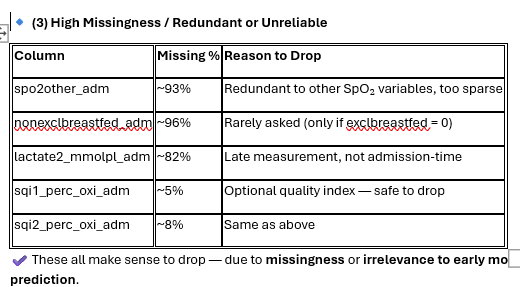
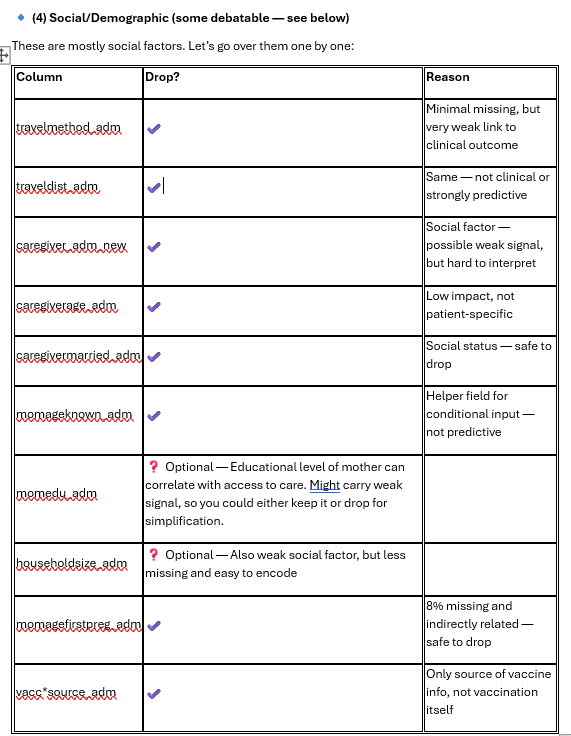

</details>

In [ ]:
# Save the cleaned and preprocessed data
print("💾 Saving cleaned data...")
df.to_csv('processed_data.csv', index=False)
print(f"✅ Saved cleaned data to 'processed_data.csv'")
print(f"📊 Shape: {df.shape}")
print(f"🎯 Ready for ML pipeline in main notebook!")


In [ ]:
# -------- STEP 2: Define Columns to Drop --------
# Intervention features
intervention_cols = [f'admitabx_adm___{i}' for i in range(1, 22)]

# High-missing or irrelevant social/administrative columns
other_cols_to_drop = [
    'studyid_adm', #Study ID 
    #high missing value
    'spo2other_adm', #SPO2 from other devices (93.2%)
    'lactate2_mmolpl_adm', # Lactate #2 (mmol/L) - (82.5%)
    'sqi1_perc_oxi_adm', # Oximeter signal-quality index 1 (%) - 4.8%
    'sqi2_perc_oxi_adm', # Oximeter signal-quality index 2 (%) - 7.7%
    'travelmethod_adm', # Method of travel to facility
    'traveldist_adm', # Time to travel to the hospital
    'caregiver_adm_new', #Who is this child's primary caregiver
    'caregiverage_adm', # Primary caregiver age 
    'caregivermarried_adm', #Current marital status of primary caregiver
    'momageknown_adm', #Is mother's age known?
    'momagefirstpreg_adm', #Is the child's mother's age at first pregnancy known?
    'nonexclbreastfed_adm', # “Was the child not exclusively breast-fed before 6 months?”
    'vaccdptsource_adm', #What is the source of the information regarding DPT/Penta vaccination? (5.3%)
    'vaccpneumocsource_adm', #What is the source of the information regarding DPT/Penta vaccination?
    'vaccmeaslessource_adm', #What is the source of the information regarding measles vaccination? (35.2%)
    'spo2site2_pc_oxi_adm', #Oxygen saturation (measure 2) - 7.6%
    #'symptoms_adm___18',
    #'comorbidity_adm___12',
    'lengthadm', #length of admission (outcome-based features)
    'momalive_adm', #Is the child's mother alive?
    'momage_adm', #How old is the child's mother?
    'priorweekabx_adm', #Was the child given antibiotics in the prior week?
    'symptoms_adm___13',
    'symptoms_adm___10', #Symptoms
    'vaccmeasles_adm'

]
numb = [3, 2, 9, 8, 6, 5]
comorbidity_cols_drop = ['comorbidity_adm___' + str(i) for i in numb]

# Additional one-hot “none” / “don’t know” cols
none_cols = [
    'comorbidity_adm___11',
    'comorbidity_adm___12',
    'symptoms_adm___18',
]

# Vaccination‐source fields
vax_source_cols = [
    'vaccdptsource_adm',
    'vaccpneumocsource_adm',
]

# Social‐household cols (if dropping socioeconomic features)
socio_cols = [
    'householdsize_adm', 'alivechildren_adm', 'deadchildren_adm',
    *[f'cookfuel_adm___{i}' for i in range(1,8)],
    'cookloc_adm', 'lightfuel_adm',
    'tobacco_adm', 'bednet_adm',
]

# Birth‐details
birth_cols = [
    'birthdetail_adm___1','birthdetail_adm___2','birthdetail_adm___3',
    'birthdetail_adm___4','birthdetail_adm___5','birthdetail_adm___6',
    'deliveryloc_adm','birthattend_adm','duedateknown_adm',
]
# low_importance_cols = [
#     'muac_mm_adm']
columns_to_drop = intervention_cols + other_cols_to_drop + comorbidity_cols_drop + none_cols + vax_source_cols + socio_cols + birth_cols

# Drop the columns
df.drop(columns=columns_to_drop, inplace=True)

In [28]:
# -------- STEP 3: Feature Summary After Dropping --------
print("\n✅ Feature Summary AFTER Dropping Columns:")
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")

missing_after = df.isnull().sum()
print("\nTop 10 columns with most missing values:")
print(missing_after.sort_values(ascending=False).head(10))


✅ Feature Summary AFTER Dropping Columns:
Number of columns: 61
Number of rows: 2686

Top 10 columns with most missing values:
lactate_mmolpl_adm       464
hematocrit_gpdl_adm      457
momhiv_adm               201
vaccpneumoc_adm           96
vaccdpt_adm               88
exclbreastfed_adm         82
totalbreastfed_adm        53
hctpretransfusion_adm     43
height_cm_adm             14
muac_mm_adm               13
dtype: int64


🚨 Checking for Impossible/Implausible Values

🫀 PHYSIOLOGICAL MEASUREMENTS:
✅ Heart Rate: All values within normal range
✅ Systolic BP: All values within normal range
❌ Diastolic BP issues: 1 values outside 20-150 mmHg
   Range: 15.0 - 15.0
✅ BP Logic: All systolic ≥ diastolic
✅ Temperature: All values within normal range
✅ spo2site1_pc_oxi_adm: All values within 0-100%
✅ spo2onoxy_adm: All values within 0-100%

👶 DEMOGRAPHIC DATA:
✅ Age: All values within 0-18 years
✅ Height: All values within normal range
✅ Weight: All values within normal range

📊 PERCENTAGE VALUES:
✅ Hematocrit: All values within 0-100%

⌨️  DATA ENTRY ERRORS:

➖ NEGATIVE VALUES:
✅ hr_bpm_adm: No negative values
✅ sysbp_mmhg_adm: No negative values
✅ diasbp_mmhg_adm: No negative values
✅ temp_c_adm: No negative values
✅ height_cm_adm: No negative values
✅ weight_kg_adm: No negative values
✅ agecalc_adm: No negative values

📋 SUMMARY OF ISSUES FOUND:
         Column  Count          Issue_Type
diasbp_mmhg_adm      1 

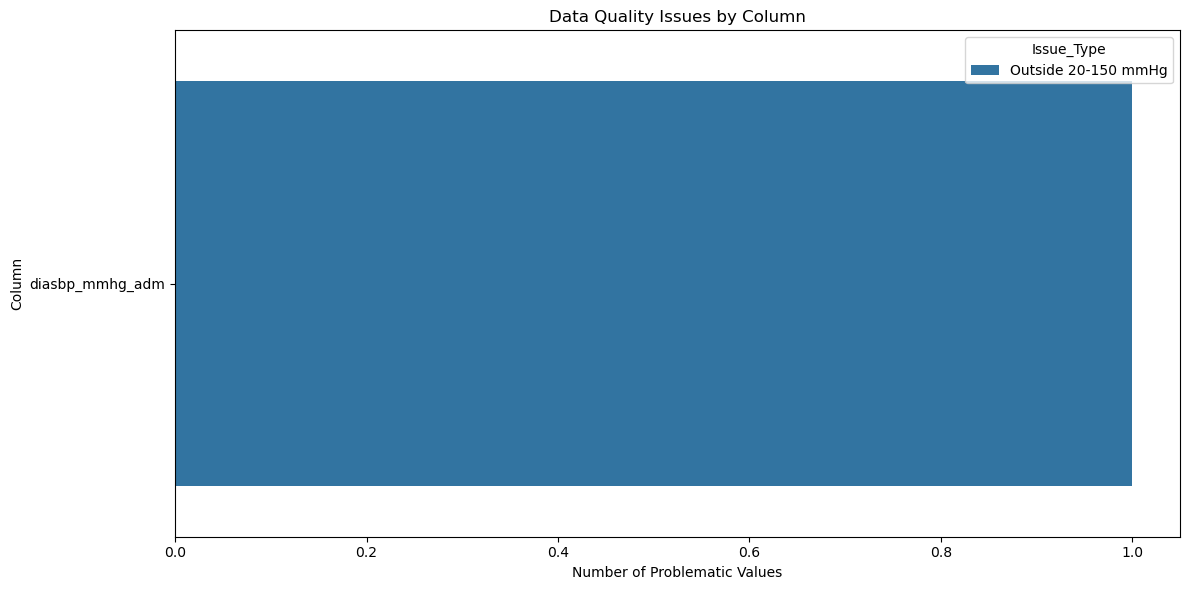

In [29]:
# -------- Check for Impossible Values in the Data --------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("🚨 Checking for Impossible/Implausible Values")
print("="*60)

def check_impossible_values(df):
    """
    Check for impossible values across different variable types
    """
    issues = []
    
    # 1. PHYSIOLOGICAL MEASUREMENTS
    print("\n🫀 PHYSIOLOGICAL MEASUREMENTS:")
    
    # Heart Rate (should be 20-300 bpm for pediatric)
    if 'hr_bpm_adm' in df.columns:
        hr_issues = df[(df['hr_bpm_adm'] < 20) | (df['hr_bpm_adm'] > 300)]['hr_bpm_adm']
        if len(hr_issues) > 0:
            print(f"❌ Heart Rate issues: {len(hr_issues)} values outside 20-300 bpm")
            print(f"   Range: {hr_issues.min():.1f} - {hr_issues.max():.1f}")
            issues.append(('hr_bpm_adm', len(hr_issues), 'Outside 20-300 bpm'))
        else:
            print(f"✅ Heart Rate: All values within normal range")
    
    # Blood Pressure (systolic should be 40-250, diastolic 20-150)
    if 'sysbp_mmhg_adm' in df.columns:
        sys_issues = df[(df['sysbp_mmhg_adm'] < 40) | (df['sysbp_mmhg_adm'] > 250)]['sysbp_mmhg_adm']
        if len(sys_issues) > 0:
            print(f"❌ Systolic BP issues: {len(sys_issues)} values outside 40-250 mmHg")
            print(f"   Range: {sys_issues.min():.1f} - {sys_issues.max():.1f}")
            issues.append(('sysbp_mmhg_adm', len(sys_issues), 'Outside 40-250 mmHg'))
        else:
            print(f"✅ Systolic BP: All values within normal range")
    
    if 'diasbp_mmhg_adm' in df.columns:
        dia_issues = df[(df['diasbp_mmhg_adm'] < 20) | (df['diasbp_mmhg_adm'] > 150)]['diasbp_mmhg_adm']
        if len(dia_issues) > 0:
            print(f"❌ Diastolic BP issues: {len(dia_issues)} values outside 20-150 mmHg")
            print(f"   Range: {dia_issues.min():.1f} - {dia_issues.max():.1f}")
            issues.append(('diasbp_mmhg_adm', len(dia_issues), 'Outside 20-150 mmHg'))
        else:
            print(f"✅ Diastolic BP: All values within normal range")
    
    # Check if systolic < diastolic (impossible)
    if 'sysbp_mmhg_adm' in df.columns and 'diasbp_mmhg_adm' in df.columns:
        bp_logic = df[df['sysbp_mmhg_adm'] < df['diasbp_mmhg_adm']]
        if len(bp_logic) > 0:
            print(f"❌ BP Logic Error: {len(bp_logic)} cases where systolic < diastolic")
            issues.append(('BP_logic', len(bp_logic), 'Systolic < Diastolic'))
        else:
            print(f"✅ BP Logic: All systolic ≥ diastolic")
    
    # Temperature (should be 30-45°C)
    if 'temp_c_adm' in df.columns:
        temp_issues = df[(df['temp_c_adm'] < 30) | (df['temp_c_adm'] > 45)]['temp_c_adm']
        if len(temp_issues) > 0:
            print(f"❌ Temperature issues: {len(temp_issues)} values outside 30-45°C")
            print(f"   Range: {temp_issues.min():.1f} - {temp_issues.max():.1f}")
            issues.append(('temp_c_adm', len(temp_issues), 'Outside 30-45°C'))
        else:
            print(f"✅ Temperature: All values within normal range")
    
    # SpO2 (should be 0-100%)
    spo2_cols = [col for col in df.columns if 'spo2' in col.lower()]
    for col in spo2_cols:
        spo2_issues = df[(df[col] < 0) | (df[col] > 100)][col]
        if len(spo2_issues) > 0:
            print(f"❌ {col} issues: {len(spo2_issues)} values outside 0-100%")
            print(f"   Range: {spo2_issues.min():.1f} - {spo2_issues.max():.1f}")
            issues.append((col, len(spo2_issues), 'Outside 0-100%'))
        else:
            print(f"✅ {col}: All values within 0-100%")
    
    # 2. DEMOGRAPHIC DATA
    print("\n👶 DEMOGRAPHIC DATA:")
    
    # Age (should be 0-18 years for pediatric, convert from months if needed)
    if 'agecalc_adm' in df.columns:
        # Assuming age is in months based on previous context
        age_years = df['agecalc_adm'] / 12
        age_issues = age_years[(age_years < 0) | (age_years > 18)]
        if len(age_issues) > 0:
            print(f"❌ Age issues: {len(age_issues)} values outside 0-18 years")
            print(f"   Range: {age_issues.min():.1f} - {age_issues.max():.1f} years")
            issues.append(('agecalc_adm', len(age_issues), 'Outside 0-18 years'))
        else:
            print(f"✅ Age: All values within 0-18 years")
    
    # Height (should be 40-200 cm for pediatric)
    if 'height_cm_adm' in df.columns:
        height_issues = df[(df['height_cm_adm'] < 40) | (df['height_cm_adm'] > 200)]['height_cm_adm']
        if len(height_issues) > 0:
            print(f"❌ Height issues: {len(height_issues)} values outside 40-200 cm")
            print(f"   Range: {height_issues.min():.1f} - {height_issues.max():.1f}")
            issues.append(('height_cm_adm', len(height_issues), 'Outside 40-200 cm'))
        else:
            print(f"✅ Height: All values within normal range")
    
    # Weight (should be 1-100 kg for pediatric)
    if 'weight_kg_adm' in df.columns:
        weight_issues = df[(df['weight_kg_adm'] < 1) | (df['weight_kg_adm'] > 100)]['weight_kg_adm']
        if len(weight_issues) > 0:
            print(f"❌ Weight issues: {len(weight_issues)} values outside 1-100 kg")
            print(f"   Range: {weight_issues.min():.1f} - {weight_issues.max():.1f}")
            issues.append(('weight_kg_adm', len(weight_issues), 'Outside 1-100 kg'))
        else:
            print(f"✅ Weight: All values within normal range")
    
    # 3. PERCENTAGE VALUES
    print("\n📊 PERCENTAGE VALUES:")
    
    # Hematocrit (should be 0-100%)
    if 'hematocrit_gpdl_adm' in df.columns:
        hct_issues = df[(df['hematocrit_gpdl_adm'] < 0) | (df['hematocrit_gpdl_adm'] > 100)]['hematocrit_gpdl_adm']
        if len(hct_issues) > 0:
            print(f"❌ Hematocrit issues: {len(hct_issues)} values outside 0-100%")
            print(f"   Range: {hct_issues.min():.1f} - {hct_issues.max():.1f}")
            issues.append(('hematocrit_gpdl_adm', len(hct_issues), 'Outside 0-100%'))
        else:
            print(f"✅ Hematocrit: All values within 0-100%")
    
    # 4. COMMON DATA ENTRY ERRORS
    print("\n⌨️  DATA ENTRY ERRORS:")
    
    # Check for common error codes (999, 9999, -999, etc.)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    error_codes = [999, 9999, -999, -9999, 888, 8888]
    
    for code in error_codes:
        for col in numeric_cols:
            error_count = (df[col] == code).sum()
            if error_count > 0:
                print(f"❌ {col}: {error_count} values = {code} (likely error code)")
                issues.append((col, error_count, f'Error code {code}'))
    
    # Check for impossible zeros (where zero doesn't make sense)
    zero_impossible_cols = ['hr_bpm_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'temp_c_adm', 'height_cm_adm', 'weight_kg_adm']
    for col in zero_impossible_cols:
        if col in df.columns:
            zero_count = (df[col] == 0).sum()
            if zero_count > 0:
                print(f"⚠️  {col}: {zero_count} zero values (check if plausible)")
                issues.append((col, zero_count, 'Zero values'))
    
    # 5. NEGATIVE VALUES WHERE NOT POSSIBLE
    print("\n➖ NEGATIVE VALUES:")
    
    always_positive = ['hr_bpm_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'temp_c_adm', 'height_cm_adm', 'weight_kg_adm', 'agecalc_adm']
    for col in always_positive:
        if col in df.columns:
            neg_count = (df[col] < 0).sum()
            if neg_count > 0:
                print(f"❌ {col}: {neg_count} negative values")
                issues.append((col, neg_count, 'Negative values'))
            else:
                print(f"✅ {col}: No negative values")
    
    return issues

# Run the check
impossible_values = check_impossible_values(df)

# Create summary table
if impossible_values:
    print(f"\n📋 SUMMARY OF ISSUES FOUND:")
    issues_df = pd.DataFrame(impossible_values, columns=['Column', 'Count', 'Issue_Type'])
    print(issues_df.to_string(index=False))
    
    # Plot the issues
    plt.figure(figsize=(12, 6))
    sns.barplot(data=issues_df, x='Count', y='Column', hue='Issue_Type')
    plt.title('Data Quality Issues by Column')
    plt.xlabel('Number of Problematic Values')
    plt.tight_layout()
    plt.show()
else:
    print(f"\n🎉 NO IMPOSSIBLE VALUES DETECTED!")

In [30]:
# -------- FIX THE IDENTIFIED ISSUES --------
print("\n" + "="*50)
print("🧹 FIXING IDENTIFIED ISSUES")
print("="*50)

# Fix the diastolic BP value of 15.0 mmHg
problematic_mask = (df['diasbp_mmhg_adm'] < 20) | (df['diasbp_mmhg_adm'] > 150)
df.loc[problematic_mask, 'diasbp_mmhg_adm'] = np.nan
print(f"✅ Fixed {problematic_mask.sum()} diastolic BP values")

print("🎯 Data cleaning complete - issues have been resolved!")


🧹 FIXING IDENTIFIED ISSUES
✅ Fixed 1 diastolic BP values
🎯 Data cleaning complete - issues have been resolved!


In [ ]:
import numpy as np
import pandas as pd

# --------------------------------------------------------------------------
# 1.  MEAN ARTERIAL PRESSURE (MAP)  &  SHOCK INDEX
# --------------------------------------------------------------------------
df['map_mmHg']     = (df['sysbp_mmhg_adm'] + 2 * df['diasbp_mmhg_adm']) / 3
df['shock_index']  = df['hr_bpm_adm'] / df['sysbp_mmhg_adm']

# ------------------------------------------------------------------
#  NEW age-adjusted heart-rate feature: percentage of PALS upper limit
# ------------------------------------------------------------------
def pals_upper_hr(age_months):
    if age_months < 3:
        return 205
    elif age_months < 24:
        return 190
    elif age_months < 120:
        return 140
    else:
        return 100

df['hr_pct_of_limit'] = (
    df['hr_bpm_adm'] /
    df['agecalc_adm'].apply(pals_upper_hr)
)

# Optional: flag tachycardia > 110 % of limit
df['tachy_flag'] = (df['hr_pct_of_limit'] > 1.1).astype('Int8')


# --------------------------------------------------------------------------
# 3.  SUPPLEMENTAL-OXYGEN STATUS  →  on_oxygen_flag  (0 = room air)
# --------------------------------------------------------------------------
# If oxygenavail_adm is numeric codes 1–4  … else use string mapping
oxygen_map_num = {1:1, 2:0, 3:1, 4:0}
oxygen_map_str = {
    "Oxygen available and being used"      : 1,
    "Oxygen available and not being used"  : 0,
    "Oxygen available but not enough"      : 1,
    "Oxygen not available"                 : 0
}

if pd.api.types.is_numeric_dtype(df['oxygenavail_adm']):
    df['on_oxygen_flag'] = df['oxygenavail_adm'].map(oxygen_map_num).astype('Int8')
else:
    df['on_oxygen_flag'] = df['oxygenavail_adm'].map(oxygen_map_str).astype('Int8')

# --------------------------------------------------------------------------
# 4.  HYPOXIA FLAG  (SpO₂ < 90 on ROOM AIR)
# --------------------------------------------------------------------------
df['hypoxia_flag'] = (
    (df['spo2site1_pc_oxi_adm'] < 90) &
    (df['on_oxygen_flag'] == 0)                    # 0 = room air
).astype('Int8')

# --------------------------------------------------------------------------
# 5.  BLANTYRE COMA SCALE  (numerical mapping 0-2)
# --------------------------------------------------------------------------
bcs_maps = {
    'bcsmotor_adm': {  # Motor responses
        'Localizes painful stimulus'             : 2,
        'Withdraws limb from painful stimulus'   : 1,
        'No response or inappropriate response'  : 0
    },
    'bcseye_adm': {    # Eye responses
        'Watches or follows'                     : 2,
        'Fails to watch or follow'               : 1,
        'Eyes do not open'                       : 0    
    },
    'bcsverbal_adm': { # Verbal responses
        'Cries appropriately with pain, or, if verbal, speaks' : 2,
        'Moan or abnormal cry with pain'                      : 1,
        'No vocal response to pain'                           : 0
    }
}

# --- Apply mapping --------------------------------------------------------
for col, mapping in bcs_maps.items():
    if col in df.columns:
        # Ensure we’re mapping on strings (not category codes)
        df[col] = df[col].astype(str).map(mapping).astype('Int8')

        # Create missing flag (1 if mapping failed -> NaN)
        df[f'{col}_missing'] = df[col].isna().astype('Int8')

# ---------------- missing flags for BCS parts ------------------------------
for col in bcs_maps:
    df[f'{col}_missing'] = df[col].isna().astype('Int8')

# ---------------- total BCS (0-5) & coma flag ------------------------------
df['bcs_total'] = df[[*bcs_maps]].sum(axis=1, skipna=False)

# Two alternative coma thresholds — pick ONE of the following lines:
df['coma_flag'] = (df['bcs_total'] <= 2).astype('Int8')      # classic ≤2/5 (deep coma)
# df['coma_flag'] = (df['bcs_total'] <= 8).astype('Int8')    # if you rescale to GCS-like

# --------------------------------------------------------------------------
# 6.  LACTATE CATEGORIES
# --------------------------------------------------------------------------
df['lactate_cat'] = pd.cut(
    df['lactate_mmolpl_adm'],       # assumes still numeric / NaN
    bins   = [0, 2, 4, 15],
    labels = ['normal', 'moderate', 'high']
)

# Optional numeric flag for “lactate missing”
df['lactate_missing'] = df['lactate_mmolpl_adm'].isna().astype('Int8')

# --------------------------------------------------------------------------
# 7.   Create missing flags for ALL new numeric engineered columns
# --------------------------------------------------------------------------
new_num_cols = ['map_mmHg', 'shock_index', 'hr_pct_of_limit']
for col in new_num_cols:
    df[f'{col}_missing'] = df[col].isna().astype('Int8')

print("✅  Early feature-engineering complete.")


✅  Early feature-engineering complete.


<details>
<summary><b>📋 Click to expand: Data Tiers</b></summary>

| Tier                        | Dataset column(s) (exact names)                                                                                                                | Why they matter (papers)                                                                                                                            | Practical tips / possible engineering                                                                   |               |                               |
| --------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- | ------------- | ----------------------------- |
| **1 High-impact “core”**    | **lactate\_mmolpl\_adm**                                                                                                                       | Lactate is *the* strongest single predictor across mortality models (Yuniar 2023: AUROC ≈ 0.75 solo; VIS + lactate AUROC ≈ 0.90)                    | • Bin into {<2, 2–4, >4 mmol/L} <br>• Create a “missing lactate” flag—absence itself can be informative |               |                               |
|                             | **sysbp\_mmhg\_adm**, **diasbp\_mmhg\_adm**                                                                                                    | Hypotension is part of PRISM-III/PELOD and VIS; strong mortality signal (Dewan alert, PRISM, pSOFA)                                                 | • Derive **MAP** = (SBP + 2×DBP)/3 <br>• Derive **Shock Index** = HR/SBP                                |               |                               |
|                             | **caprefill\_adm**, **respdistress\_adm**                                                                                                      | Perfusion delay ≥ 3 s and severe respiratory distress were explicit trigger criteria in Dewan et al.; both reflect shock severity                   | • Binary as is; no imputation—missing = assume normal                                                   |               |                               |
|                             | **hr\_bpm\_adm** (with age)                                                                                                                    | Extreme tachycardia in context of low BP → high VIS proxy; widely used in pSOFA & early-warning scores                                              | • Add interaction or ratio with age group (child vs infant)                                             |               |                               |
|                             | **rr\_brpm\_app\_adm**, **spo2site1\_pc\_oxi\_adm** & **oxygenavail\_adm**                                                                     | High RR ± hypoxia signal impending respiratory failure; used in pSOFA; Ratz review lists RR & SpO₂ among top features                               | • Flag hypoxia < 90 % on room air vs on O₂                                                              |               |                               |
|                             | **bcseye\_adm**, **bcsmotor\_adm**, **bcsverbal\_adm**                                                                                         | Altered mental status (low BCS/GCS) is organ-dysfunction criterion; included in PRISM-III, PELOD                                                    | • Sum to total BCS; flag “BCS ≤ 8” as coma                                                              |               |                               |
| **2 Useful “supporting”**   | **platelet\_ct10e3ul\_adm** (if present), **wbc\_ct\_pl\_adm**                                                                                 | Thrombocytopenia and leukopenia feature in PELOD-2 and multiple mortality models                                                                    | • Bin low platelets (<100 × 10³) <br>• Bin WBC < 4 or > 15 k/µL                                         |               |                               |
|                             | **temp\_c\_adm**                                                                                                                               | Hypothermia at presentation is a bad prognostic sign (often stronger than fever)                                                                    | • Flag temp < 36 °C or > 39 °C                                                                          |               |                               |
|                             | **muac\_mm\_adm**                                                                                                                              | Review notes MUAC feasible in LMICs; proxy for nutrition; severe malnutrition worsens outcome                                                       | • Keep as continuous; optionally flag MUAC < 115 mm                                                     |               |                               |
|                             | **spo2site2\_pc\_oxi\_adm**                                                                                                                    | Second sensor reading—useful for calculating **SpO₂ delta** (artifact detection)                                                                    | • Calculate                                                                                             | SpO₂₁ − SpO₂₂ | > 3 % as a “poor signal” flag |
| **3 Context / exploratory** | **traveldist\_adm** (actually travel-time hours)                                                                                               | Long delays to hospital could correlate with more advanced disease; not in literature but plausible                                                 | • Keep **only** if < 25 % missing; test non-linear effect                                               |               |                               |
|                             | **hivstatus\_adm**, **malariastatuspos\_adm**                                                                                                  | Immunosuppression/co-infection absent from core models but clinically plausible modifiers                                                           | • Include for subgroup models; drop otherwise                                                           |               |                               |
| **Drop / ignore**           | All **admitabx\_adm\_\_\_#**, detailed immunization sources, household fuel/water fields, symptom check-boxes, other comorbidity “other” flags | Not used in any mortality model; low physiologic relevance; interventions or sociocultural context better handled outside mortality risk prediction |                                                                                                         |               |                               |
Start with Tier-1 variables (plus age and sex) to build a compact baseline model.

Add Tier-2; compare AUROC, AUPRC, calibration. Keep if you see material gain (> 0.01 AUROC or better calibration).

Experiment with limited Tier-3 variables only if you have spare model capacity and low missingness.

Drop everything else—it will only add noise or leakage.

Track missingness: if any Tier-1 feature exceeds ~30 % missing, create a “Missing_X” indicator so models can learn from the pattern rather than losing all rows.

This pared-down, literature-anchored feature set should get you closest to the signal that matters for pediatric-sepsis mortality while keeping the model small, interpretable, and portable.

In [32]:
df.columns

Index(['agecalc_adm', 'height_cm_adm', 'weight_kg_adm', 'muac_mm_adm',
       'hr_bpm_adm', 'rr_brpm_app_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm',
       'temp_c_adm', 'spo2site1_pc_oxi_adm', 'hematocrit_gpdl_adm',
       'lactate_mmolpl_adm', 'glucose_mmolpl_adm', 'sex_adm', 'spo2onoxy_adm',
       'oxygenavail_adm', 'respdistress_adm', 'caprefill_adm', 'bcseye_adm',
       'bcsmotor_adm', 'bcsverbal_adm', 'bcgscar_adm', 'vaccpneumoc_adm',
       'vaccdpt_adm', 'priorweekantimal_adm', 'symptoms_adm___1',
       'symptoms_adm___2', 'symptoms_adm___3', 'symptoms_adm___4',
       'symptoms_adm___5', 'symptoms_adm___6', 'symptoms_adm___7',
       'symptoms_adm___8', 'symptoms_adm___9', 'symptoms_adm___11',
       'symptoms_adm___12', 'symptoms_adm___14', 'symptoms_adm___15',
       'symptoms_adm___16', 'comorbidity_adm___1', 'comorbidity_adm___4',
       'comorbidity_adm___7', 'comorbidity_adm___10', 'priorhosp_adm',
       'prioryearwheeze_adm', 'prioryearcough_adm', 'diarrheaoften_adm'

In [33]:
tier1_important = ['lactate_mmolpl_adm','sysbp_mmhg_adm','diasbp_mmhg_adm',
                  'hr_bpm_adm','rr_brpm_app_adm','spo2site1_pc_oxi_adm',
                  'caprefill_adm','bcsverbal_adm']

# Create missing flags BEFORE any imputation
for col in tier1_important:
    if col in df.columns:
        df[f'{col}_missing'] = df[col].isna().astype(int)
# -------- PREPROCESSING PIPELINE SETUP --------
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

print("🔧 Setting up ML Preprocessing Pipeline")
print("="*50)

# 1. Identify column groups after all our preprocessing
num_cols = df.select_dtypes(include=['float64','int64','Int8']).columns.tolist()
cat_cols = df.select_dtypes(include='category').columns.tolist()

# Remove the target from lists
target = 'inhospital_mortality'
num_cols = [c for c in num_cols if c != target]
cat_cols = [c for c in cat_cols if c != target]

print(f"Feature Summary:")
print(f"  • Numeric columns: {len(num_cols)}")
print(f"  • Categorical columns: {len(cat_cols)}")
print(f"  • Total features: {len(num_cols) + len(cat_cols)}")

# Show some examples
print(f"\n Sample numeric columns: {num_cols[:5]}")
print(f"  Sample categorical columns: {cat_cols[:5]}")

# 2. Create preprocessing pipelines
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
                    handle_unknown='ignore',
                    sparse_output=False,
                    drop='first'  # Avoid multicollinearity
               ))
])

# 3. Combine into one preprocessor
preproc = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])  

print(f"\n Preprocessing pipeline created!")
print(f"  • Numeric pipeline: Median imputation → Standardization")
print(f"  • Categorical pipeline: Mode imputation → One-hot encoding")

# 4. Prepare data for ML
print(f"\nPreparing train/test split...")

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

print(f"  • Features shape: {X.shape}")
print(f"  • Target distribution: {y.value_counts().to_dict()}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class balance
)

print(f"  • Train set: {X_train.shape[0]} samples")
print(f"  • Test set: {X_test.shape[0]} samples")

# 5. Fit and transform the data
print(f"\n🔄 Applying preprocessing...")

# Fit on training data and transform both sets
X_train_processed = preproc.fit_transform(X_train)
X_test_processed = preproc.transform(X_test)

print(f"  • Processed train shape: {X_train_processed.shape}")
print(f"  • Processed test shape: {X_test_processed.shape}")

# Get feature names after preprocessing
def get_feature_names(preprocessor, num_cols, cat_cols):
    """Get feature names after preprocessing"""
    feature_names = []
    
    # Numeric feature names (unchanged)
    feature_names.extend(num_cols)
    
    # Categorical feature names (one-hot encoded)
    if len(cat_cols) > 0:
        try:
            cat_transformer = preprocessor.named_transformers_['cat']
            encoder = cat_transformer.named_steps['encoder']
            cat_feature_names = encoder.get_feature_names_out(cat_cols)
            feature_names.extend(cat_feature_names)
        except:
            # Fallback if we can't get feature names
            feature_names.extend([f"cat_feature_{i}" for i in range(X_train_processed.shape[1] - len(num_cols))])
    
    return feature_names

feature_names = get_feature_names(preproc, num_cols, cat_cols)
print(f"  • Total features after encoding: {len(feature_names)}")

# 6. Convert back to DataFrames for easier analysis (optional)
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print(f"\n🎉 Preprocessing Complete!")
print(f"  • Ready for machine learning models")
print(f"  • No missing values: {X_train_df.isnull().sum().sum() == 0}")
print(f"  • All features are numeric: {X_train_df.select_dtypes(include=['number']).shape[1] == X_train_df.shape[1]}")

# 7. Show sample of processed data
print(f"\n📊 Sample of processed data:")
print(X_train_df.head(3))

print(f"\n💾 Variables available for modeling:")
print(f"  • X_train_processed, X_test_processed (numpy arrays)")
print(f"  • X_train_df, X_test_df (pandas DataFrames)")  
print(f"  • y_train, y_test (target variables)")
print(f"  • preproc (fitted preprocessor for new data)")
print(f"  • feature_names (list of all feature names)")

🔧 Setting up ML Preprocessing Pipeline
📊 Feature Summary:
  • Numeric columns: 57
  • Categorical columns: 18
  • Total features: 75

🔢 Sample numeric columns: ['agecalc_adm', 'height_cm_adm', 'weight_kg_adm', 'muac_mm_adm', 'hr_bpm_adm']
🏷️  Sample categorical columns: ['sex_adm', 'oxygenavail_adm', 'vaccpneumoc_adm', 'vaccdpt_adm', 'priorweekantimal_adm']

✅ Preprocessing pipeline created!
  • Numeric pipeline: Median imputation → Standardization
  • Categorical pipeline: Mode imputation → One-hot encoding

📋 Preparing train/test split...
  • Features shape: (2686, 83)
  • Target distribution: {0: 2567, 1: 119}
  • Train set: 2148 samples
  • Test set: 538 samples

🔄 Applying preprocessing...
  • Processed train shape: (2148, 115)
  • Processed test shape: (538, 115)
  • Total features after encoding: 115

🎉 Preprocessing Complete!
  • Ready for machine learning models
  • No missing values: True
  • All features are numeric: True

📊 Sample of processed data:
      agecalc_adm  heigh

In [ ]:
df.to_csv(df.to_csv('processed_data_ver4.csv', index=False))


',agecalc_adm,height_cm_adm,weight_kg_adm,muac_mm_adm,hr_bpm_adm,rr_brpm_app_adm,sysbp_mmhg_adm,diasbp_mmhg_adm,temp_c_adm,spo2site1_pc_oxi_adm,hematocrit_gpdl_adm,lactate_mmolpl_adm,glucose_mmolpl_adm,sex_adm,spo2onoxy_adm,oxygenavail_adm,respdistress_adm,caprefill_adm,bcseye_adm,bcsmotor_adm,bcsverbal_adm,bcgscar_adm,vaccpneumoc_adm,vaccdpt_adm,priorweekantimal_adm,symptoms_adm___1,symptoms_adm___2,symptoms_adm___3,symptoms_adm___4,symptoms_adm___5,symptoms_adm___6,symptoms_adm___7,symptoms_adm___8,symptoms_adm___9,symptoms_adm___11,symptoms_adm___12,symptoms_adm___14,symptoms_adm___15,symptoms_adm___16,comorbidity_adm___1,comorbidity_adm___4,comorbidity_adm___7,comorbidity_adm___10,priorhosp_adm,prioryearwheeze_adm,prioryearcough_adm,diarrheaoften_adm,tbcontact_adm,feedingstatus_adm,exclbreastfed_adm,totalbreastfed_adm,badhealthduration_adm,momagefirstpregknown_adm,momedu_adm,momhiv_adm,watersource_adm,waterpure_adm,hctpretransfusion_adm,hivstatus_adm,malariastatuspos_adm,inhospital